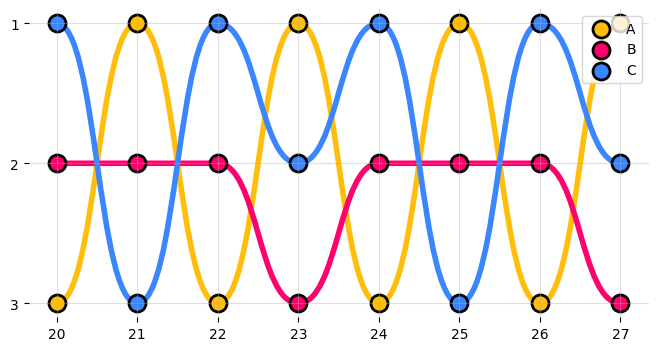

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from bumplot import bumplot

data = pd.DataFrame(
    {
        "x": [20, 21, 22, 23, 24, 25, 26, 27],
        "A": 2*[10, 50, 20, 80],
        "B": 2*[40, 30, 60, 10],
        "C": 2*[90, 20, 70, 40],
    }
)

fig, ax = plt.subplots(figsize=(8, 4))
bumplot(
    x="x",
    y_columns=["A", "B", "C"],
    data=data,
    curve_force=0.5,
    plot_kwargs={"lw": 4},
    scatter_kwargs={"s": 150, "ec": "black", "lw": 2},
    colors=["#ffbe0b", "#ff006e", "#3a86ff"],
)
ax.legend()
ax.spines[["top", "right", "left", "bottom"]].set_visible(False)
ax.grid(alpha=0.4)